In [88]:
import ast
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
import pandas as pd
import tensorflow as tf
import os
import re
from matplotlib.patches import Patch
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

# Ground-truth nonlinear effect functions (assumed to be defined elsewhere in your code)
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")
    if var_type == 'df':
        # print(f"{save_path}/{var_name}_{scenario_index}.csv")
        return pd.read_csv(f"{save_path}/{var_name}_{scenario_index}.csv")

def transform_param_eta(eta_str):
    """
    Transforms an R-style spline term like:
      s(Z1, k = 11, bs = "cr")
    into a Python-style term:
      spline(Z1, bs='bs', df=9)
    Assumes that df = k - 2.
    Also transforms "(Intercept)" to "Intercept".
    """
    # Replace "(Intercept)" with "Intercept"
    eta_str = eta_str.replace("(Intercept)", "Intercept")
    
    pattern = r"s\((Z\d),\s*k\s*=\s*(\d+),\s*bs\s*=\s*['\"]cr['\"]\)"
    match = re.match(pattern, eta_str)
    if match:
        var = match.group(1)
        k_val = int(match.group(2))
        df_val = k_val - 1
        return f"spline({var}, bs='bs', df={df_val})"
    else:
        # Return the original string if it doesn't match the pattern.
        return eta_str

def convert_r_value_string(value_str):
    """
    Converts an R-style value string like:
      "c(-0.957615792751312)"
    or
      "c(0.00564139103516936, 0.0298147071152925, ...)"
    into a Python-style list string "[...]" so that it can be parsed.
    """
    value_str = value_str.strip()
    
    if value_str.startswith("c(") and value_str.endswith(")"):
        # Remove the leading "c(" and trailing ")"
        inner = value_str[2:-1].strip()
        # Replace commas with spaces so np.fromstring can parse it correctly.
        inner = inner.replace(",", " ")
        return f"[{inner}]"
    else:
        return value_str


In [89]:
def derive_true_coefficients(X, true_linear_effects):
    """
    Derives the effective "true" coefficients from stored scaled covariates X and the
    true linear effects.

    Parameters
    ----------
    X : numpy.ndarray, shape (I, n_samples)
        The scaled covariates, where I is the number of features (e.g. 2 for X1 and X2).
    true_linear_effects : numpy.ndarray, shape (I, n_samples, K)
        The true linear effects for each structured covariate and each parameter group.
        Here, K is the number of parameter groups (e.g., for 'loc' and 'scale').
        The overall true effect for parameter group k for a given sample is computed as:
            eta_{j,k} = sum_{i=1}^{I} true_linear_effects[i, j, k].

    Returns
    -------
    beta : numpy.ndarray, shape (K, I)
        For each parameter group k, returns the estimated coefficients beta_{k} 
        (as obtained via least squares) so that for each sample j:
            eta_{j,k} ≈ X[:, j]^T beta_{k}.
    """
    # Transpose X to shape (n_samples, I)
    X_t = X.T  # shape (n_samples, I)
    
    # Sum over the feature dimension (axis=0) in true_linear_effects to obtain overall effects.
    # This yields an array of shape (n_samples, K)
    overall_effect = np.sum(true_linear_effects, axis=0)
    
    n_samples, K = overall_effect.shape
    I = X.shape[0]
    beta = np.zeros((K, I))
    
    # For each parameter group k, solve the least-squares problem:
    # X_t @ beta_k ≈ overall_effect[:, k]
    for k in range(K):
        y_k = overall_effect[:, k]  # shape (n_samples,)
        beta_k, residuals, rank, s = np.linalg.lstsq(X_t, y_k, rcond=None)
        beta[k, :] = beta_k  # beta_k has shape (I,)
    
    return beta

# # Example usage:
# # Suppose X is of shape (2, 100) and true_linear_effects is of shape (2, 100, 2):
# I = 2
# n_samples = 100
# K = 2
# # For demonstration, generate dummy data:
# X = read_with_var_name('X', 'npy', read_path, scenario_index)  # scaled covariates in [0,1]
# # Suppose the true coefficients (scaled) are:

# # Compute the true linear effects for each sample and each group:
# # For each group k, effect = sum_i beta[k, i] * X[i, :]
# true_linear_effects = read_with_var_name('linear_effects', 'npy', read_path, scenario_index)


# # Now derive the coefficients from the stored data:
# beta_est = derive_true_coefficients(X, true_linear_effects)
# print("Derived true coefficients (each row is a parameter group):")
# print(beta_est)


In [90]:
z1_grid = np.linspace(0, 1, 100)
term_Z1 = f"spline(Z1, bs='bs', df={16+2})"
spline_basis = dmatrix(f"bs(x, df={16+2}, include_intercept=True)",
                                    {"x": z1_grid}, return_type='dataframe')
B = spline_basis.to_numpy()

In [91]:
spline_basis.columns

Index(['Intercept', 'bs(x, df=18, include_intercept=True)[0]',
       'bs(x, df=18, include_intercept=True)[1]',
       'bs(x, df=18, include_intercept=True)[2]',
       'bs(x, df=18, include_intercept=True)[3]',
       'bs(x, df=18, include_intercept=True)[4]',
       'bs(x, df=18, include_intercept=True)[5]',
       'bs(x, df=18, include_intercept=True)[6]',
       'bs(x, df=18, include_intercept=True)[7]',
       'bs(x, df=18, include_intercept=True)[8]',
       'bs(x, df=18, include_intercept=True)[9]',
       'bs(x, df=18, include_intercept=True)[10]',
       'bs(x, df=18, include_intercept=True)[11]',
       'bs(x, df=18, include_intercept=True)[12]',
       'bs(x, df=18, include_intercept=True)[13]',
       'bs(x, df=18, include_intercept=True)[14]',
       'bs(x, df=18, include_intercept=True)[15]',
       'bs(x, df=18, include_intercept=True)[16]',
       'bs(x, df=18, include_intercept=True)[17]'],
      dtype='object')

In [108]:
def plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                          python_estimate_path, r_estimate_path):
    """
    Plots the estimated spline curves for Z1 and Z2.
    
    If combined=True (default), both Python (blue) and R (red) curves are overlaid
    in a single figure with two subplots (one for Z1, one for Z2).
    
    If combined=False, two separate figures are generated:
      - One for Python results (Z1 and Z2 subplots in blue)
      - One for R results (Z1 and Z2 subplots in red)
    
    Note: Before plotting, each estimated spline is centered (i.e. its mean is subtracted)
          and the true nonlinear effects are similarly centered.
    """
    z1_grid = np.linspace(0, 1, 100)
    z2_grid = np.linspace(0, 1, 100)
    
    fig_py, axes_py = plt.subplots(1, 2, figsize=(14, 6))
    for rep in range(n_reps):
        scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
        try:
            coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
        except FileNotFoundError:
            print(f"Python file not found for {scenario_index}.")
            continue
        # Z1
        term_Z1 = f"spline(Z1, bs='bs', df={n_knots+3})"
        df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
        if not df_Z1_py.empty:
            coeff_str = df_Z1_py['value'].iloc[0]
            estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
            # if bias_reconstruct:
            spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                    {"x": z1_grid}, return_type='dataframe')
            # else:
            # spline_basis = dmatrix(f"bs(x, df={n_knots+2}, include_intercept=False)",
            #                         {"x": z1_grid}, return_type='dataframe')
            if 'Intercept' in spline_basis.columns:
                spline_basis = spline_basis.drop('Intercept', axis=1)
            B = spline_basis.to_numpy()
            f_est = B.dot(estimated_coeffs)
            # Center the estimated spline:
            f_est = f_est - np.mean(f_est)
            axes_py[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                            zorder=1)
        # Z2
        term_Z2 = f"spline(Z2, bs='bs', df={n_knots+3})"
        df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
        if not df_Z2_py.empty:
            coeff_str = df_Z2_py['value'].iloc[0]
            estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
            # if bias_reconstruct:
            spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                    {"x": z2_grid}, return_type='dataframe')
            # else:
            # spline_basis = dmatrix(f"bs(x, df={n_knots+2}, include_intercept=False)",
            #                         {"x": z2_grid}, return_type='dataframe')
            if 'Intercept' in spline_basis.columns:
                spline_basis = spline_basis.drop('Intercept', axis=1)
            B = spline_basis.to_numpy()
            f_est = B.dot(estimated_coeffs)
            # Center the estimated spline:
            f_est = f_est - np.mean(f_est)
            axes_py[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
                            zorder=1)
    # Overlay true effects
    true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
    true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
    true_effect_Z1 = true_effect_Z1 - np.mean(true_effect_Z1)
    true_effect_Z2 = true_effect_Z2 - np.mean(true_effect_Z2)
    axes_py[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
    axes_py[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
    axes_py[0].set_xlabel(r'$Z_1$')
    axes_py[0].set_ylabel(r'$f_1(Z_1)$')
    axes_py[0].set_title("Python: Estimated Splines for Z1")
    axes_py[0].legend()
    axes_py[1].set_xlabel(r'$Z_2$')
    axes_py[1].set_ylabel(r'$f_2(Z_2)$')
    axes_py[1].set_title("Python: Estimated Splines for Z2")
    axes_py[1].legend()
    plt.tight_layout()
    py_filename = os.path.join(python_estimate_path, "python_estimated_splines.png")
    plt.savefig(py_filename)
    plt.show()
    print(f"Python-only figure saved as {py_filename}")
        
    # R figure
    fig_r, axes_r = plt.subplots(1, 2, figsize=(14, 6))
    for rep in range(n_reps):
        scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
        try:
            coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
            coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
        except FileNotFoundError:
            print(f"R file not found for {scenario_index}.")
            continue
        # Z1
        term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
        df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
        if not df_Z1_r.empty:
            coeff_str = df_Z1_r['value'].iloc[0]
            coeff_str = convert_r_value_string(coeff_str)
            estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
            # print(estimated_coeffs)
            # if bias_reconstruct:
            spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=True)",
                                    {"x": z1_grid}, return_type='dataframe')
            # else:
            # spline_basis = dmatrix(f"bs(x, df={n_knots+2}, include_intercept=False)",
            #                         {"x": z1_grid}, return_type='dataframe')
            if 'Intercept' in spline_basis.columns:
                spline_basis = spline_basis.drop('Intercept', axis=1)
            B = spline_basis.to_numpy()
            f_est = B.dot(estimated_coeffs)
            # Center the estimated spline:
            f_est = f_est - np.mean(f_est)
            axes_r[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
                            zorder=1)
        # Z2
        term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
        df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
        if not df_Z2_r.empty:
            coeff_str = df_Z2_r['value'].iloc[0]
            coeff_str = convert_r_value_string(coeff_str)
            estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
            # print(estimated_coeffs)

            # if bias_reconstruct:
            spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=True)",
                                    {"x": z2_grid}, return_type='dataframe')
            # else:
            # spline_basis = dmatrix(f"bs(x, df={n_knots+2}, include_intercept=False)",
            #                         {"x": z2_grid}, return_type='dataframe')
            if 'Intercept' in spline_basis.columns:
                spline_basis = spline_basis.drop('Intercept', axis=1)
            B = spline_basis.to_numpy()
            f_est = B.dot(estimated_coeffs)
            # Center the estimated spline:
            f_est = f_est - np.mean(f_est)
            axes_r[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
                            zorder=1)
    # Overlay true effects
    true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
    true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
    true_effect_Z1 = true_effect_Z1 - np.mean(true_effect_Z1)
    true_effect_Z2 = true_effect_Z2 - np.mean(true_effect_Z2)
    axes_r[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
    axes_r[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
    axes_r[0].set_xlabel(r'$Z_1$')
    axes_r[0].set_ylabel(r'$f_1(Z_1)$')
    axes_r[0].set_title("R: Estimated Splines for Z1")
    axes_r[0].legend()
    axes_r[1].set_xlabel(r'$Z_2$')
    axes_r[1].set_ylabel(r'$f_2(Z_2)$')
    axes_r[1].set_title("R: Estimated Splines for Z2")
    axes_r[1].legend()
    plt.tight_layout()
    r_filename = os.path.join(python_estimate_path, "r_estimated_splines.png")
    plt.savefig(r_filename)
    plt.show()
    print(f"R-only figure saved as {r_filename}")


In [105]:
def plot_linear_boxplots(n, n_reps, d, snr, method,
                         python_estimate_path, r_estimate_path, true_path):
    """
    Reads Python estimates, R estimates, and true values (if any),
    and plots them as grouped boxplots for each parameter (e.g. 'loc', 'scale', etc.).
    
    - If Python or R data for a term is missing, that box is skipped.
    - For True data, if there is only one unique value, a horizontal line is plotted;
      otherwise, a boxplot is shown.
    - Each term is placed at one x-axis group location, with Python, R, and possibly True boxes (or line) side by side.
    """
    
    # Containers for estimated coefficients
    results_py = {}
    results_r = {}
    true_values = {}

    # -------------------------------------------------------------------------
    # 1) Read estimates and true values over all replicates
    # -------------------------------------------------------------------------
    for rep in range(n_reps):
        scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
        scenario_X = f"n_{n}_rep_{rep}"
        # ------------------ Read Python estimates ------------------
        try:
            coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            param_types_py = coeff_dict_py['param_y'].unique()
            param_eta_values_py = coeff_dict_py['param_eta'].unique()
        except FileNotFoundError:
            print(f"Python file not found for {scenario_index}. Skipping replicate.")
            continue

        # Dynamically initialize/update results_py
        for param in param_types_py:
            if param not in results_py:
                results_py[param] = {term: [] for term in param_eta_values_py}
            else:
                # Add new terms if they appear
                for term in param_eta_values_py:
                    if term not in results_py[param]:
                        results_py[param][term] = []

            # Fill data (only if val.size == 1)
            for term in param_eta_values_py:
                df_term = coeff_dict_py[
                    (coeff_dict_py['param_y'] == param) &
                    (coeff_dict_py['param_eta'] == term)
                ]
                if not df_term.empty:
                    val = np.fromstring(df_term['value'].iloc[0].strip("[]"), sep=" ")
                    if val.size == 1:
                        results_py[param][term].append(val[0])
                    # else: spline or multi-value: skip

        # ------------------ Read R estimates ------------------
        try:
            coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
            coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
            param_types_r = coeff_dict_r['param_y'].unique()
            param_eta_values_r = coeff_dict_r['param_eta'].unique()
        except FileNotFoundError:
            print(f"R file not found for {scenario_index}.")
            continue  # Skip this replicate if R data is missing

        # Dynamically initialize/update results_r
        for param in param_types_r:
            if param not in results_r:
                results_r[param] = {term: [] for term in param_eta_values_r}
            else:
                for term in param_eta_values_r:
                    if term not in results_r[param]:
                        results_r[param][term] = []

            # Fill data (only if val.size == 1)
            for term in param_eta_values_r:
                df_term = coeff_dict_r[
                    (coeff_dict_r['param_y'] == param) &
                    (coeff_dict_r['param_eta'] == term)
                ]
                if not df_term.empty:
                    raw_str = df_term['value'].iloc[0]
                    conv_str = convert_r_value_string(raw_str)
                    val = np.fromstring(conv_str.strip("[]"), sep=" ")
                    if val.size == 1:
                        results_r[param][term].append(val[0])
                    # else: skip multi-value

        # ------------------ Read/derive True values ------------------
        try:
            X_struct = read_with_var_name('X', 'npy', true_path, scenario_X)
            true_lin_eff = read_with_var_name('linear_effects', 'npy', true_path, scenario_X)
            derived_beta = derive_true_coefficients(X_struct, true_lin_eff)
            
            # Suppose we only do something special if d == "gaussian_homo"
            for param in param_types_py:
                if param not in true_values:
                    true_values[param] = {term: [] for term in param_eta_values_py}
                if d == "gaussian_homo":
                    if param == "loc":
                        true_values[param]['Intercept'].append(0)
                        true_values[param]['X1'].append(derived_beta[0, 0])
                        true_values[param]['X2'].append(derived_beta[0, 1])
                    elif param == "scale":
                        a_val = read_with_var_name('a', 'npy', true_path,
                                                   f"{scenario_X}_dist_{d}_SNR_{snr}")
                        true_values[param]['Intercept'].append(a_val)
        except Exception as e:
            print(f"Error deriving true coefficients for {scenario_index}: {e}")

    # -------------------------------------------------------------------------
    # 2) Plotting: group Python, R, and True side-by-side for each term
    # -------------------------------------------------------------------------
    params = list(results_py.keys())
    n_params = len(params)

    if n_params == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(n_params, 1, figsize=(10, 6 * n_params))

    for ax, param in zip(axes, params):
        term_keys = list(results_py[param].keys())  # All terms for this param

        group_data = []      # Data for boxplots
        positions = []       # x positions for each box
        box_colors = []      # color for each box
        tick_positions = []  # center of each group
        tick_labels = []     # label for each group

        # For recording true values that should be plotted as lines
        true_line_info = {}

        pos = 1.0  # starting x-position for the first group

        for term in term_keys:
            py_data = results_py.get(param, {}).get(term, [])
            r_data  = results_r.get(param, {}).get(term, [])
            t_data  = true_values.get(param, {}).get(term, [])

            term_group_data = []
            term_positions = []
            term_colors = []

            # Python box (if available)
            if len(py_data) > 0:
                term_group_data.append(py_data)
                term_positions.append(pos)
                term_colors.append('blue')
                pos += 0.6

            # R box (if available)
            if len(r_data) > 0:
                term_group_data.append(r_data)
                term_positions.append(pos)
                term_colors.append('red')
                pos += 0.6

            # True values: if available
            if len(t_data) > 0:
                unique_vals = np.unique(t_data)
                if unique_vals.size == 1:
                    # Instead of a boxplot, record that a horizontal line should be drawn.
                    # We'll record the group's center later.
                    # Here, we don't add to term_group_data.
                    true_line_info[term] = unique_vals[0]
                    # Optionally, reserve some space.
                    pos += 0.6
                else:
                    term_group_data.append(t_data)
                    term_positions.append(pos)
                    term_colors.append('green')
                    pos += 0.6

            # Finalize the group for this term if there's at least one box
            if term_group_data:
                group_data.extend(term_group_data)
                positions.extend(term_positions)
                box_colors.extend(term_colors)
                group_center = np.mean(term_positions) if term_positions else pos - 0.3
                tick_positions.append(group_center)
                tick_labels.append(term)
                pos += 1.0  # extra spacing between groups
            else:
                # Even if no box was added, if a true_line is recorded, we still want a tick label.
                if term in true_line_info:
                    tick_positions.append(pos - 0.3)
                    tick_labels.append(term)
                else:
                    print(f"No data to plot for {param}, term '{term}'")

        if group_data:
            bp = ax.boxplot(group_data, positions=positions, patch_artist=True, widths=0.5)
            for patch, color in zip(bp['boxes'], box_colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha="right")
            ax.set_title(f"{param.capitalize()} Coefficients")
            ax.set_ylabel("Coefficient Value")
        else:
            ax.set_title(f"{param.capitalize()} Coefficients")
            ax.set_ylabel("Coefficient Value")
            ax.text(0.5, 0.5, f"No data to plot for '{param}'", 
                    transform=ax.transAxes, ha='center', va='center')

        # Now overlay true value lines for those terms that have a unique true value.
        for term, val in true_line_info.items():
            # Find the tick position corresponding to this term.
            try:
                idx = tick_labels.index(term)
                xpos = tick_positions[idx]
                # Draw a horizontal line marker at xpos. We'll span a small width.
                ax.hlines(val, xpos - 0.3, xpos + 0.3, colors='green', linestyles='-', lw=2, label="True" if idx==0 else "")
            except ValueError:
                pass

        # Create a legend for the boxes and line
        legend_handles = [
            Patch(facecolor='blue',  label='Python', alpha=0.6),
            Patch(facecolor='red',   label='R',       alpha=0.6),
            Patch(facecolor='green', label='True (box)', alpha=0.6)
        ]
        ax.legend(handles=legend_handles)
        
    plt.tight_layout()
    out_file = os.path.join(python_estimate_path, "linear_boxplots_generalized.png")
    plt.savefig(out_file)
    plt.show()
    print(f"Generalized boxplot figure saved as {out_file}")


In [ ]:
# Parameters (adjust as needed)
n = 1000
n_reps = 100
d = "gaussian_homo"

n_knots = 6   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs_nonlinear_nknots_6_batch_32"
r_estimate_path = "../../SSDR/results/point_estimates_nonlinear"
true_path = "../data_generation/output_nonlinear"
# true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}




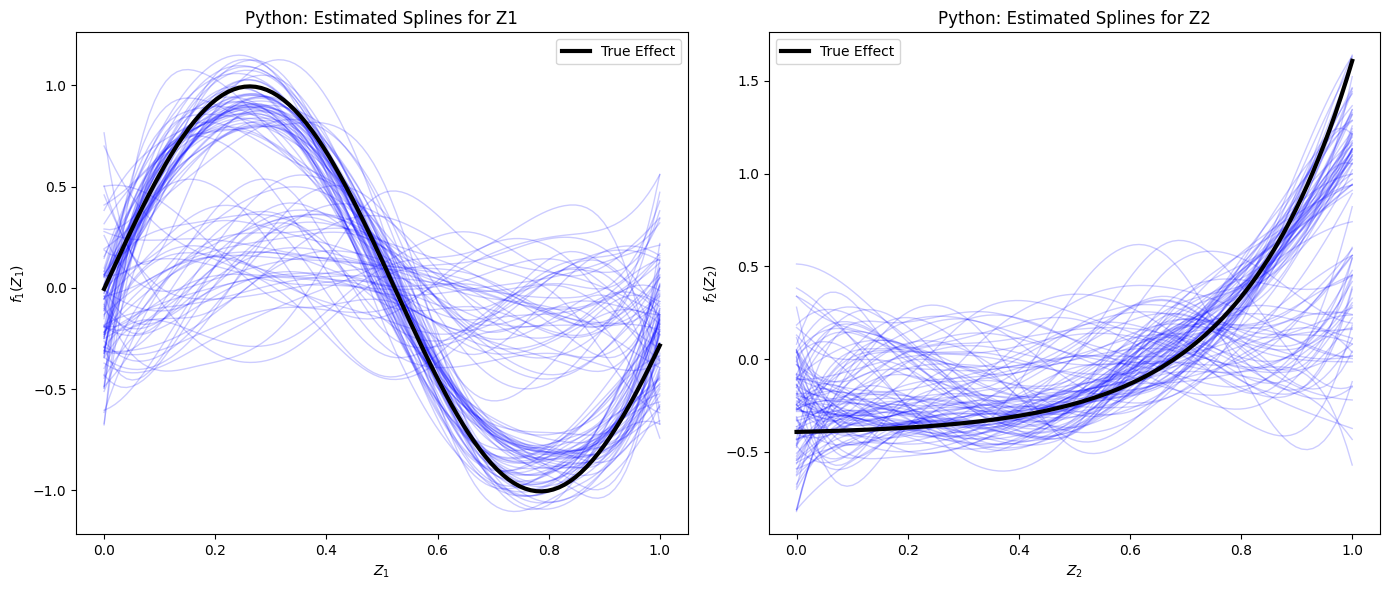

Python-only figure saved as ./outputs_nonlinear_nknots_6_batch_32/python_estimated_splines.png


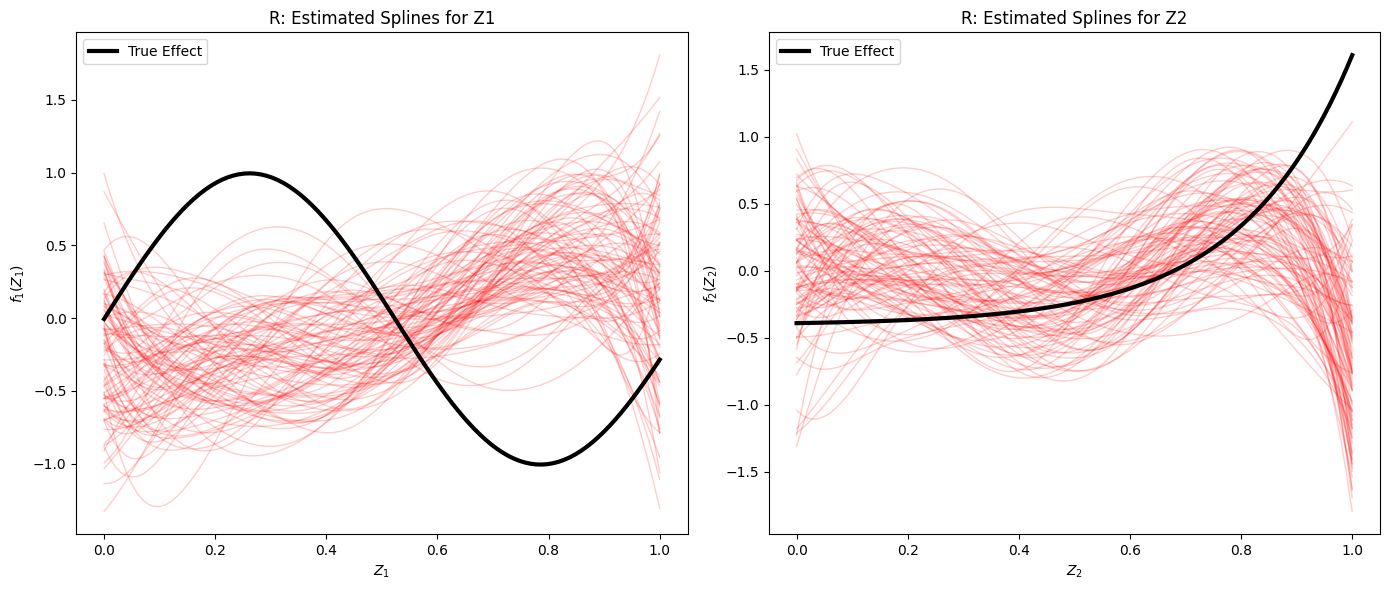

R-only figure saved as ./outputs_nonlinear_nknots_6_batch_32/r_estimated_splines.png


In [ ]:
snr = 1
# Plot spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path)


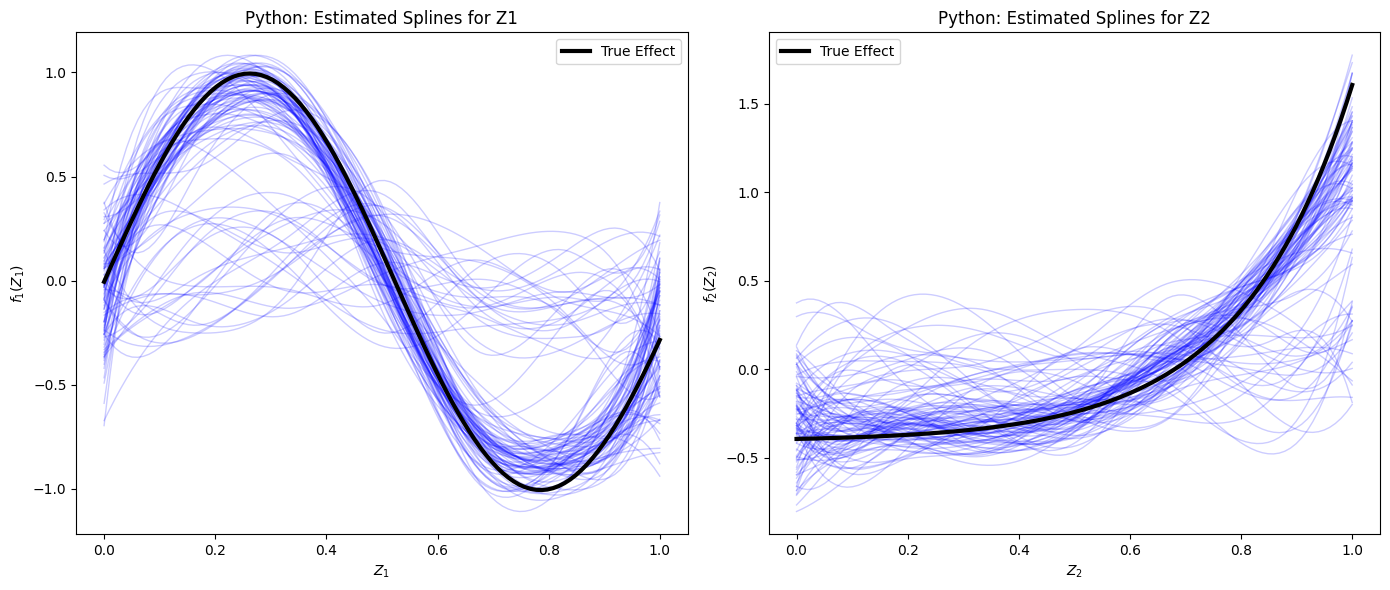

Python-only figure saved as ./outputs_nonlinear_nknots_6_batch_32/python_estimated_splines.png


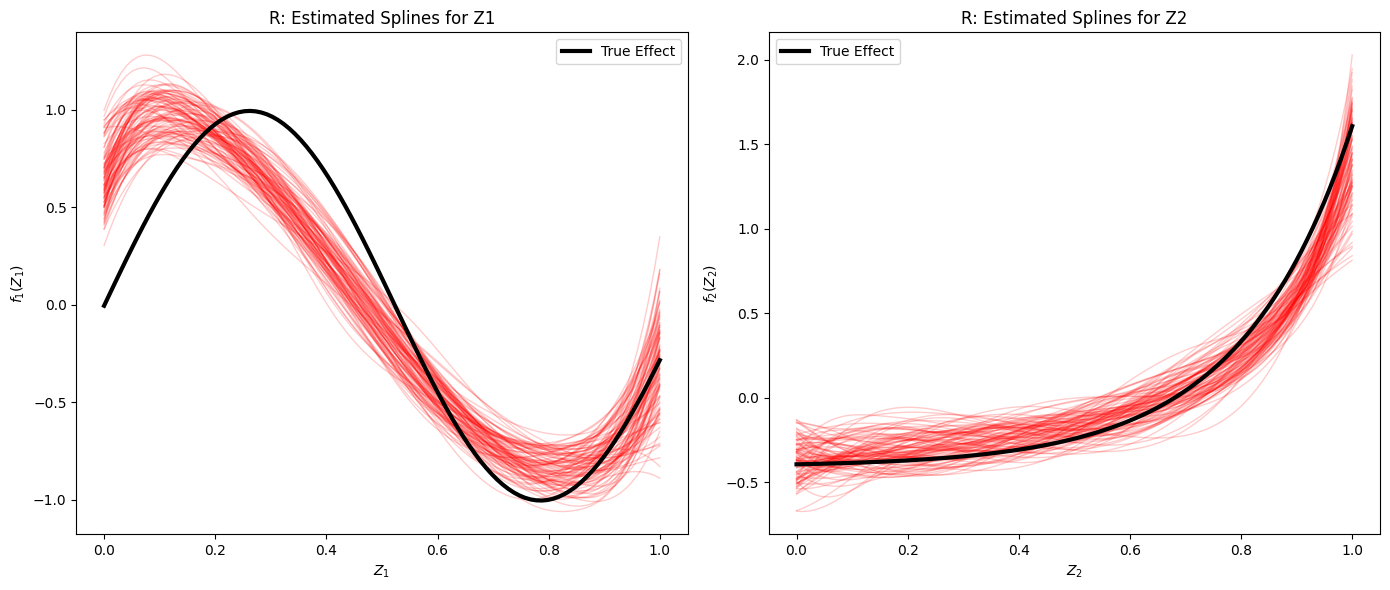

R-only figure saved as ./outputs_nonlinear_nknots_6_batch_32/r_estimated_splines.png


In [109]:
snr = 8
# Plot spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path)

./outputs_linear_nknots_16_batch_32/point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_8_point_estimates.csv
../../SSDR/results/point_estimates_linear/point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_8_point_estimates.csv
./outputs_linear_nknots_16_batch_32/point_estimates_n_1000_rep_1_dist_gaussian_homo_SNR_8_point_estimates.csv
../../SSDR/results/point_estimates_linear/point_estimates_n_1000_rep_1_dist_gaussian_homo_SNR_8_point_estimates.csv
./outputs_linear_nknots_16_batch_32/point_estimates_n_1000_rep_2_dist_gaussian_homo_SNR_8_point_estimates.csv
../../SSDR/results/point_estimates_linear/point_estimates_n_1000_rep_2_dist_gaussian_homo_SNR_8_point_estimates.csv
./outputs_linear_nknots_16_batch_32/point_estimates_n_1000_rep_3_dist_gaussian_homo_SNR_8_point_estimates.csv
../../SSDR/results/point_estimates_linear/point_estimates_n_1000_rep_3_dist_gaussian_homo_SNR_8_point_estimates.csv
./outputs_linear_nknots_16_batch_32/point_estimates_n_1000_rep_4_dist_gaussian_homo_SNR_8_point_

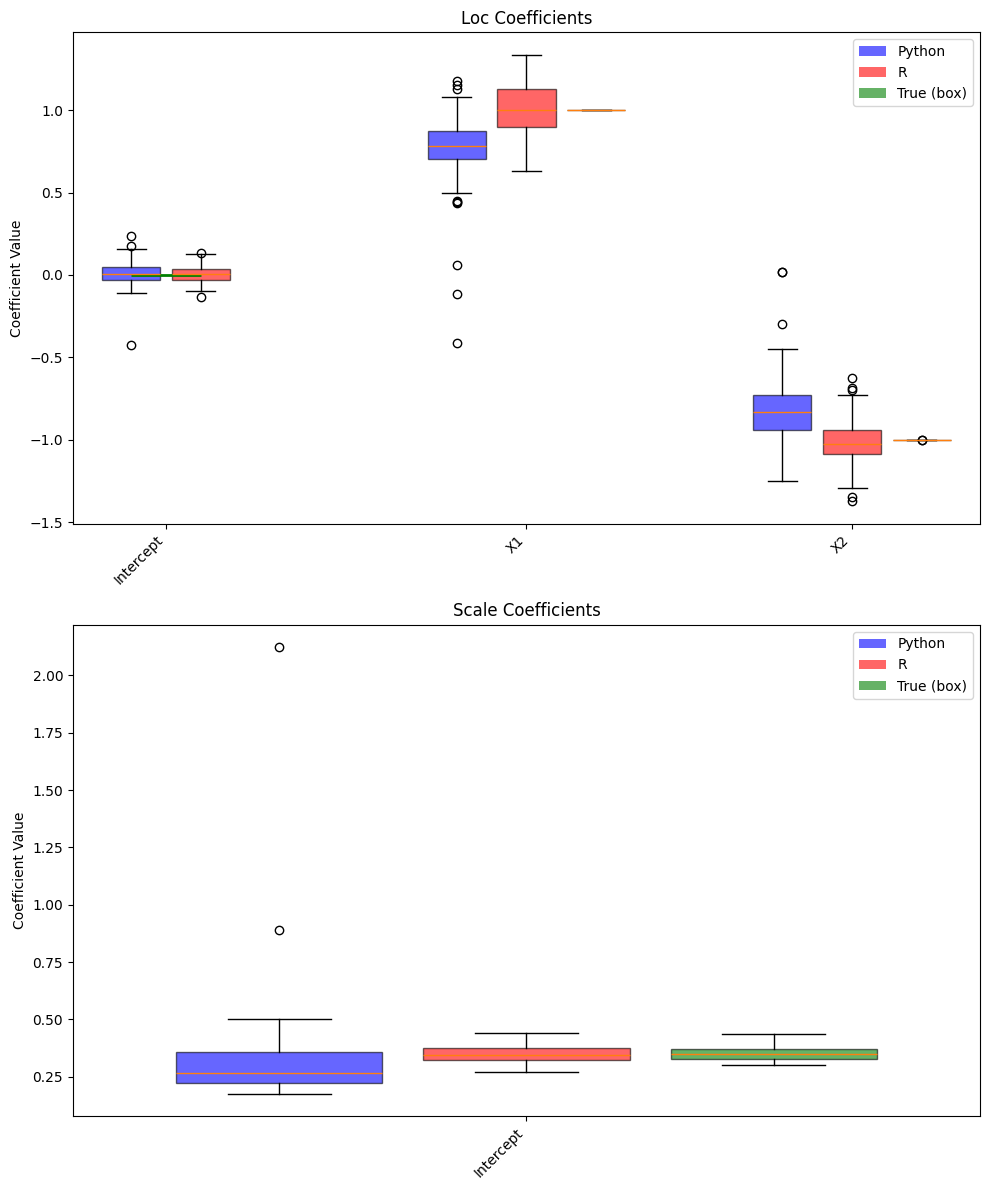

Generalized boxplot figure saved as ./outputs_linear_nknots_16_batch_32/linear_boxplots_generalized.png


In [6]:
# Parameters (adjust as needed)
n = 1000
n_reps = 100
d = "gaussian_homo"
snr = 8
n_knots = 16   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs_linear_nknots_16_batch_32"
r_estimate_path = "../../SSDR/results/point_estimates_linear"
true_path = "../data_generation/output_linear"
# true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}

# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path)


./outputs_linear_nknots_16_batch_32//point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_1_point_estimates.csv
../../SSDR/results/point_estimates_linear//point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_1_point_estimates.csv
./outputs_linear_nknots_16_batch_32//point_estimates_n_1000_rep_1_dist_gaussian_homo_SNR_1_point_estimates.csv
../../SSDR/results/point_estimates_linear//point_estimates_n_1000_rep_1_dist_gaussian_homo_SNR_1_point_estimates.csv
./outputs_linear_nknots_16_batch_32//point_estimates_n_1000_rep_2_dist_gaussian_homo_SNR_1_point_estimates.csv
../../SSDR/results/point_estimates_linear//point_estimates_n_1000_rep_2_dist_gaussian_homo_SNR_1_point_estimates.csv
./outputs_linear_nknots_16_batch_32//point_estimates_n_1000_rep_3_dist_gaussian_homo_SNR_1_point_estimates.csv
../../SSDR/results/point_estimates_linear//point_estimates_n_1000_rep_3_dist_gaussian_homo_SNR_1_point_estimates.csv
./outputs_linear_nknots_16_batch_32//point_estimates_n_1000_rep_4_dist_gaussian_homo_SNR

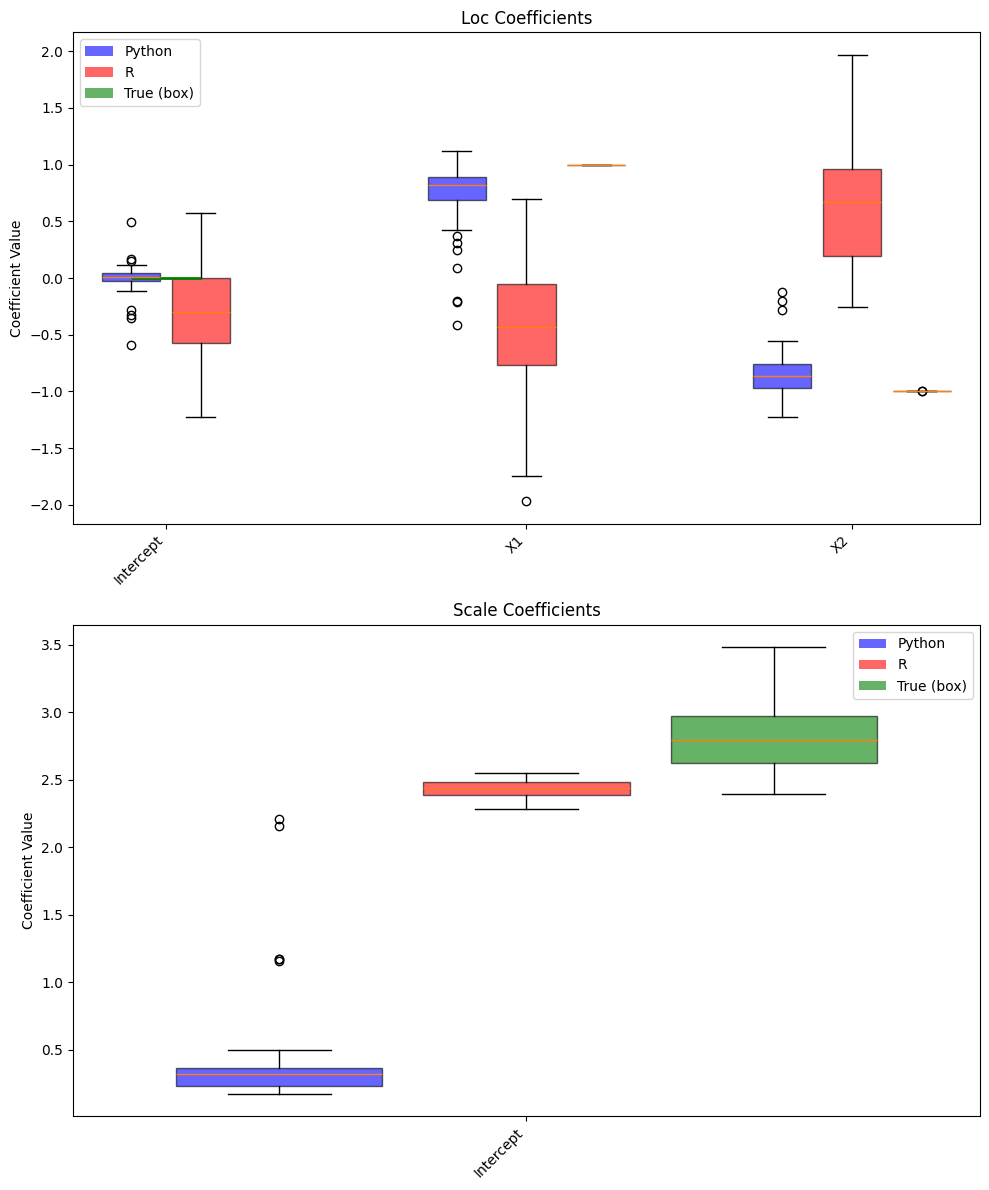

Generalized boxplot figure saved as ./outputs_linear_nknots_16_batch_32/linear_boxplots_generalized.png


In [ ]:
snr = 1
# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path)


In [14]:
XX = gam.generate_X_grid(term=2)

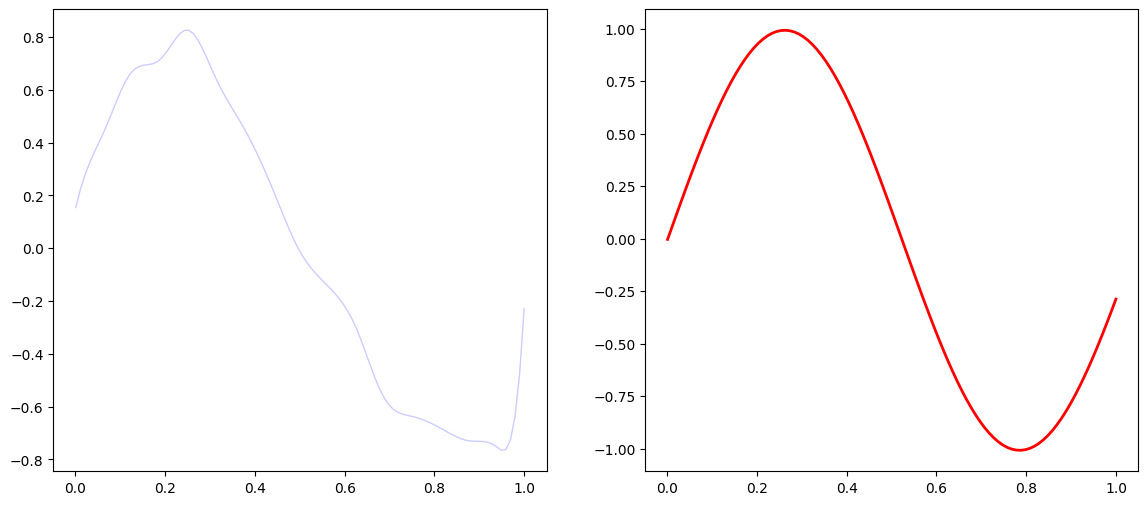

In [ ]:
z1_grid = XX[:,2]
n = 1000
reps = 0
d = "gaussian_homo"
snr = 8
n_knots = 16   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs_wo_unstructured_nknots_16/"
r_estimate_path = "../../SSDR/results/point_estimates_wo_unstructured/"
true_path = "../data_generation/output_wo_unstructured"
bias_reconstruct = True

scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
fig_py, axes_py = plt.subplots(1, 2, figsize=(14, 6))
# Python estimates (blue)
try:
    coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
except FileNotFoundError:
    print(f"Python file not found for {scenario_index}.")
    coeff_dict_py = None

if coeff_dict_py is not None:
    # For Z1
    term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
    df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
    if not df_Z1_py.empty:
        coeff_str = df_Z1_py['value'].iloc[0]
        estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
        if bias_reconstruct:
            spline_basis = dmatrix(f"bs(x, df={n_knots+2}, include_intercept=True)",
                                    {"x": z1_grid}, return_type='dataframe')
        else:
            spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                    {"x": z1_grid}, return_type='dataframe')
            if 'Intercept' in spline_basis.columns:
                spline_basis = spline_basis.drop('Intercept', axis=1)
        B_1 = spline_basis.to_numpy()
        f_est = B_1.dot(estimated_coeffs)
        # Center the estimated spline by subtracting its mean:
        f_est = f_est - np.mean(f_est)
        axes_py[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                                zorder=1)

pdep, confi = gam.partial_dependence(term=2, X=XX, width=0.95)
# If the confidence intervals are not provided per grid point, replicate them.
if confi.ndim == 1 or confi.shape[0] != XX.shape[0]:
    confi = np.tile(confi, (XX.shape[0], 1))
axes_py[1].plot(XX[:, 2], pdep, color='red', lw=2)


In [11]:
# Generate grid for term=2 (which corresponds to Z1 in our specification)
XX = gam.generate_X_grid(term=2)
# Get the design matrix for that term:
B = gam._modelmat(XX, term=2)
print("Design matrix shape for Z1 spline:", B.shape)  # Expect (n_points, 20)

Design matrix shape for Z1 spline: (100, 20)


In [12]:
B

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 398 stored elements and shape (100, 20)>

In [5]:
!pip install pygam


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/scratch/ipykernel_1666565/1424133143.py:44: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      40.808
Link Function:                     IdentityLink Log Likelihood:                         -435064723907.4618
Number of Samples:                         1000 AIC:                                     870129447898.5394
                                                AICc:                                    870129447902.2789
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

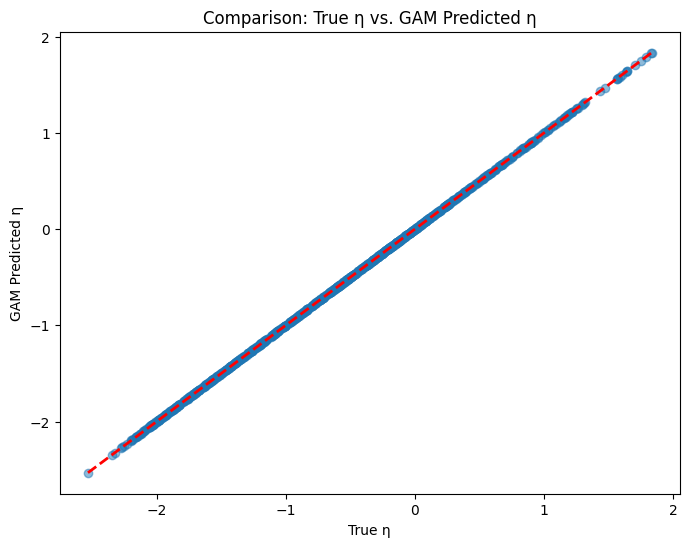

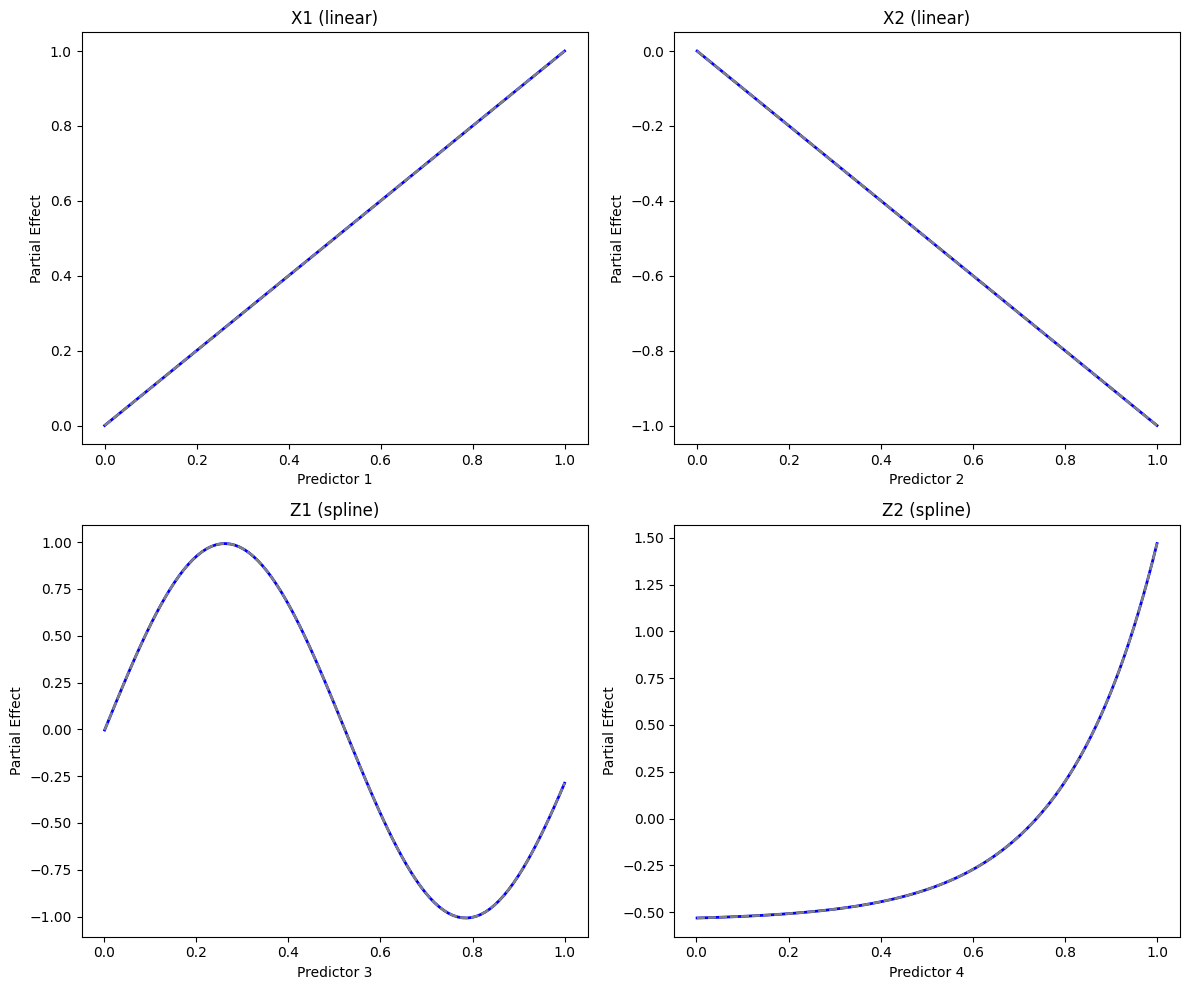

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, l
import os
import scipy.sparse as sp

# --- Monkey-patch: Override .A for both csr_matrix and csc_matrix ---
sp.csr_matrix.A = property(lambda self: self.toarray())
sp.csc_matrix.A = property(lambda self: self.toarray())

# --- Helper: mimic your sddr read function ---
def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    # Extend as needed for other var_types.

# --- Set paths and scenario details ---
save_path = "../data_generation/output_wo_unstructured"  # Change as needed.
n = 1000          # number of samples
rep = 0           # choose a replication index for comparison
scenario_index = f"n_{n}_rep_{rep}"

# --- Read structured predictors from the saved files ---
X = read_with_var_name('X', 'npy', save_path, scenario_index)  # Expected shape: (2, n_samples)
linear_effects = read_with_var_name('linear_effects', 'npy', save_path, scenario_index)  # Expected shape: (2, n_samples)

Z = read_with_var_name('Z', 'npy', save_path, scenario_index)  # Expected shape: (2, n_samples)

# Transpose so that rows are observations:
X_transposed = X.T   # shape: (n_samples, 2)
Z_transposed = Z.T   # shape: (n_samples, 2)

# Combine into a DataFrame with columns X1, X2, Z1, Z2.
df = pd.DataFrame(np.hstack((X_transposed, Z_transposed)),
                  columns=['X1', 'X2', 'Z1', 'Z2'])

# --- Read true eta ---
eta_all = read_with_var_name('etas', 'npy', save_path, scenario_index + "_dist_gaussian_homo_SNR_1")
eta_true = eta_all[:, 0]  # use the first column as the true η

# --- Fit a GAM to predict η ---
gam = LinearGAM(l(0) + l(1) + s(2) + s(3))
gam.gridsearch(df.values, eta_true)  # Automatically tunes smoothing parameters

print(gam.summary())

# --- Compare predicted η versus true η ---
eta_pred = gam.predict(df.values)

plt.figure(figsize=(8,6))
plt.scatter(eta_true, eta_pred, alpha=0.5)
plt.plot([eta_true.min(), eta_true.max()],
         [eta_true.min(), eta_true.max()],
         'r--', lw=2)
plt.xlabel("True η")
plt.ylabel("GAM Predicted η")
plt.title("Comparison: True η vs. GAM Predicted η")
plt.show()

# --- Partial Dependence Plots ---
fig, axs = plt.subplots(2, 2, figsize=(12,10))
titles = ['X1 (linear)', 'X2 (linear)', 'Z1 (spline)', 'Z2 (spline)']

for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    # If the confidence intervals are not provided per grid point, replicate them.
    if confi.ndim == 1 or confi.shape[0] != XX.shape[0]:
        confi = np.tile(confi, (XX.shape[0], 1))
    ax.plot(XX[:, i], pdep, color='blue', lw=2)
    ax.plot(XX[:, i], confi[:, 0], color='gray', ls='--')
    ax.plot(XX[:, i], confi[:, 1], color='gray', ls='--')
    ax.set_title(titles[i])
    ax.set_xlabel(f"Predictor {i+1}")
    ax.set_ylabel("Partial Effect")
    
plt.tight_layout()
plt.show()



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, l
import os
import scipy.sparse as sp

# --- Helper: mimic your sddr read function ---
def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    # Extend as needed for other var_types.

# --- Set paths and scenario details ---
save_path = "../data_generation/output_linear"  # Change as needed.
n = 1000          # number of samples
rep = 0           # choose a replication index for comparison
scenario_index = f"n_{n}_rep_{rep}"

# --- Read structured predictors from the saved files ---
X = read_with_var_name('X', 'npy', save_path, scenario_index)  # Expected shape: (2, n_samples)
linear_effects = read_with_var_name('linear_effects', 'npy', save_path, scenario_index)  # Expected shape: (2, n_samples)

# Transpose so that rows are observations:
X_transposed = X.T   # shape: (n_samples, 2)

# Combine into a DataFrame with columns X1, X2, Z1, Z2.
df = pd.DataFrame(X_transposed,
                  columns=['X1', 'X2'])

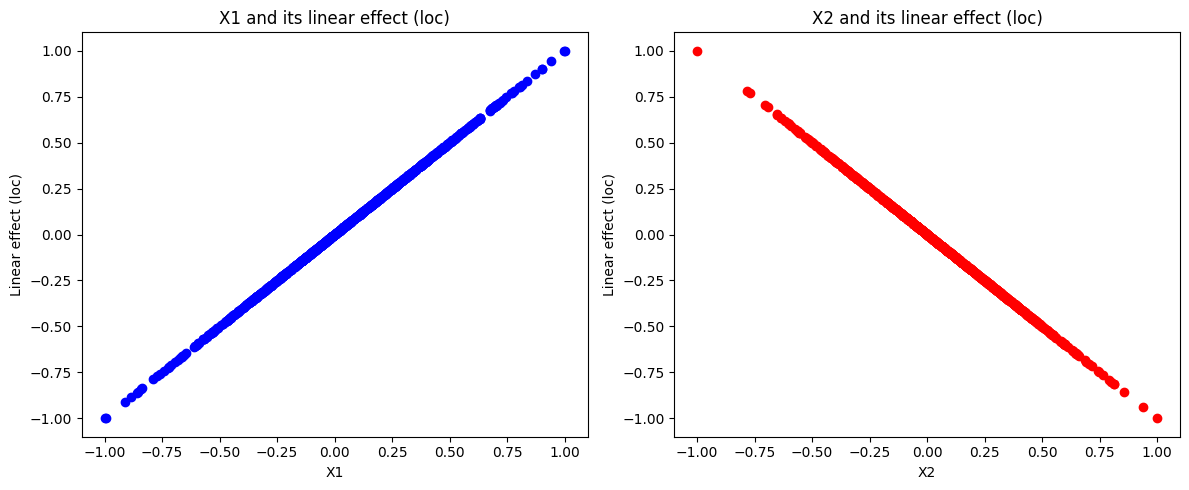

In [13]:
# Extract linear effects for location (K=0)
# linear_effects has shape (2, n_samples, 2); take K=0 and use the first index for x1 and second for x2.
linear_effects_loc = linear_effects[:, :, 0]  # shape: (2, n_samples)
linear_effect_X1 = linear_effects_loc[0, :]     # effect for X1, shape: (n_samples,)
linear_effect_X2 = linear_effects_loc[1, :]     # effect for X2, shape: (n_samples,)
# Optional: Plot the predictors against their linear effects
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(df['X1'], linear_effect_X1, color='blue')
axs[0].set_title("X1 and its linear effect (loc)")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("Linear effect (loc)")

axs[1].scatter(df['X2'], linear_effect_X2, color='red')
axs[1].set_title("X2 and its linear effect (loc)")
axs[1].set_xlabel("X2")
axs[1].set_ylabel("Linear effect (loc)")

plt.tight_layout()
plt.show()

In [9]:
df

,X1,X2
0,0.391948,0.531053
1,0.578117,0.381610
2,0.520811,0.715016
3,0.631615,0.484891
4,0.475267,0.738266
...,...,...
995,0.534750,0.444441
996,0.521449,0.597102
997,0.556143,0.240841
998,0.580229,0.495813


In [8]:
eta_true.shape

(1000,)